In [1]:
import os, json
import numpy as np
import h5py
import imageio
import urllib.request, urllib.error, urllib.parse, os, tempfile


BASE_DIR = '../datasets/coco_captioning'

def load_coco_data(base_dir=BASE_DIR, max_train=None, pca_features=True):
    
    data = {}
    caption_file = os.path.join(base_dir, 'coco2014_captions.h5')
    with h5py.File(caption_file, 'r') as f:
        for k, v in f.items():
            data[k] = np.asarray(v)
    
    if pca_features:
        train_feat_file = os.path.join(base_dir, 'train2014_vgg16_fc7_pca.h5')
    else:
        train_feat_file = os.path.join(base_dir, 'train2014_vgg16_fc7.h5')
    with h5py.File(train_feat_file, 'r') as f:
        data['train_features'] = np.asarray(f['features'])

    if pca_features:
        val_feat_file = os.path.join(base_dir, 'val2014_vgg16_fc7_pca.h5')
    else:
        val_feat_file = os.path.join(base_dir, 'val2014_vgg16_fc7.h5')
    with h5py.File(val_feat_file, 'r') as f:
        data['val_features'] = np.asarray(f['features'])

    dict_file = os.path.join(base_dir, 'coco2014_vocab.json')
    with open(dict_file, 'r') as f:
        dict_data = json.load(f)
        for k, v in dict_data.items():
            data[k] = v

    train_url_file = os.path.join(base_dir, 'train2014_urls.txt')
    with open(train_url_file, 'r') as f:
        train_urls = np.asarray([line.strip() for line in f])
    data['train_urls'] = train_urls

    val_url_file = os.path.join(base_dir, 'val2014_urls.txt')
    with open(val_url_file, 'r') as f:
        val_urls = np.asarray([line.strip() for line in f])
    data['val_urls'] = val_urls

    # Maybe subsample the training data
    if max_train is not None:
        num_train = data['train_captions'].shape[0]
        mask = np.random.randint(num_train, size=max_train)
        data['train_captions'] = data['train_captions'][mask]
        data['train_image_idxs'] = data['train_image_idxs'][mask]

    return data


def decode_captions(captions, idx_to_word):
    singleton = False
    if captions.ndim == 1:
        singleton = True
        captions = captions[None]
    decoded = []
    N, T = captions.shape
    for i in range(N):
        words = []
        for t in range(T):
            word = idx_to_word[captions[i, t]]
            if word != '<NULL>':
                words.append(word)
            if word == '<END>':
                break
        decoded.append(' '.join(words))
    if singleton:
        decoded = decoded[0]
    return decoded


def sample_coco_minibatch(data, batch_size=100, split='train'):
    split_size = data['{}_captions'.format(split)].shape[0]
    mask = np.random.choice(split_size, batch_size)
    captions = data['{}_captions'.format(split)][mask]
    image_idxs = data['{}_image_idxs'.format(split)][mask]
    image_features = data['{}_features'.format(split)][image_idxs]
    urls = data['{}_urls'.format(split)][image_idxs]
    return captions, image_features, urls


def image_from_url(url):
    try:
        f = urllib.request.urlopen(url)
        fname = tempfile.mktemp()
        with open(fname, 'wb') as ff:
            ff.write(f.read())
        img = imageio.imread(fname)
        os.remove(fname)
        return img
    except urllib.error.URLError as e:
        print('URL Error: ', e.reason, url)
    except urllib.error.HTTPError as e:
        print('HTTP Error: ', e.code, url)

In [2]:
data = load_coco_data(pca_features=True, max_train=100)
data.keys()

dict_keys(['train_captions', 'train_image_idxs', 'val_captions', 'val_image_idxs', 'train_features', 'val_features', 'idx_to_word', 'word_to_idx', 'train_urls', 'val_urls'])

In [3]:
import time
import matplotlib.pyplot as plt
from scipy.misc import imresize

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

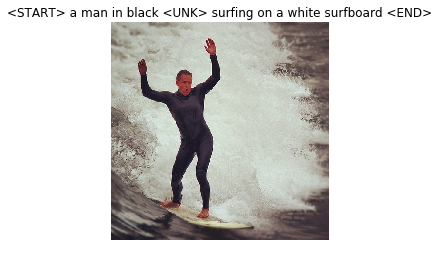

In [4]:
# Sample a minibatch and show the images and captions
batch_size = 1

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

In [5]:
features.shape

(1, 512)

In [6]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

tfe.enable_eager_execution()

In [7]:
def temporal_softmax_loss(x, y, mask, verbose=False):
    N, T, V = x.get_shape().as_list()

    x_flat = tf.reshape(x, [N * T, V]) # x.reshape(N * T, V)
    y_flat = tf.reshape(y, [N * T]) # y.reshape(N * T)
    mask_flat = tf.reshape(mask, [N * T]) # mask.reshape(N * T)
    mask_flat = tf.cast(mask_flat, dtype=tf.float32)

    probs = tf.exp(x_flat - tf.reduce_max(x_flat, axis=1, keepdims=True))
    probs /= tf.reduce_sum(probs, axis=1, keepdims=True)
    probs = tf.gather_nd(probs, tf.stack((tf.range(N * T), y_flat), -1))
    loss = -tf.reduce_sum(mask_flat * tf.log(probs)) / N

    return loss


class CaptioningRNN(object):
    def __init__(self, word_to_idx, input_dim=512, hidden_dim=128, wordvec_dim=128):
        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}
        vocab_size = len(word_to_idx)
        
        self._null = word_to_idx['<NULL>']
        self._start = word_to_idx.get('<START>', None)
        self._end = word_to_idx.get('<END>', None)
        
        # initialize layers
        initializer = tf.variance_scaling_initializer(scale=2.0)
        self.w_embed = tfe.Variable(np.random.randn(vocab_size, wordvec_dim), dtype=tf.float32)
        self.proj_layer = tf.layers.Dense(units=hidden_dim, kernel_initializer=initializer)
        
        self.hidden_dim = hidden_dim
        self.encoder_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units=hidden_dim)
        
        self.vocab_layer = tf.layers.Dense(units=vocab_size, kernel_initializer=initializer)
    
    
    def get_loss(self, features, captions):
        features = tf.convert_to_tensor(features, dtype=tf.float32)
        captions_in = tf.convert_to_tensor(captions[:, :-1], dtype=tf.int32)
        captions_out = tf.convert_to_tensor(captions[:, 1:], dtype=tf.int32)
        mask = tf.not_equal(captions_out, self._null)
        
        h0 = self.proj_layer(features)
        x = tf.nn.embedding_lookup(self.w_embed, captions_in)
        
        state = tf.nn.rnn_cell.LSTMStateTuple(c=np.zeros((features.shape[0].value, self.hidden_dim)), h=h0)
        timestep_x = tf.unstack(x, axis=1)
        outputs, cell_states = [], []
        
#         print("features shape: {}".format(features.shape))
#         print("captions_in shape: {}".format(captions_in.shape))
#         print("h0 shape: {}".format(h0.shape))
#         print("timestep_x shape: {}".format(timestep_x[0].shape))
#         print("x shape: {}".format(x.shape))
        
        for input_step in timestep_x:
#             print('input_step shape is {}'.format(input_step.shape))
            output, state = self.encoder_cell(input_step, state)
            
            outputs.append(output)
            cell_states.append(state[0])
        
        outputs = tf.stack(outputs, axis=1)
        cell_states = tf.stack(cell_states, axis=1)
        
        scores = self.vocab_layer(outputs)
        loss = temporal_softmax_loss(scores, captions_out, mask)

        return loss
    
    
    def sample(self, features, max_length=30):
        N = features.shape[0]
        captions = self._null * np.ones((N, max_length))
        captions = captions.astype(np.int32)
        
        
        h0 = self.proj_layer(features)
        x = tf.nn.embedding_lookup(self.w_embed, self._start * np.ones(N, dtype=np.int32))
        state = tf.nn.rnn_cell.LSTMStateTuple(c=np.zeros((N, self.hidden_dim)), h=h0)
        
#         print("caption type: {}".format(captions.dtype))
#         print("features shape: {}".format(features.shape))
#         print("h0 shape: {}".format(h0.shape))
#         print("x shape: {}".format(x.shape))
        
        for t in range(max_length):
            output, state = self.encoder_cell(x, state)
            scores = self.vocab_layer(output)
            
#             print("argmax type: {}".format(tf.argmax(scores, axis=1).dtype))
#             print("caption type: {}".format(captions[:, t].dtype))
            
            captions[:, t] += tf.cast(tf.argmax(scores, axis=1), tf.int32)
            x = tf.nn.embedding_lookup(self.w_embed, captions[:, t])
        
        return captions

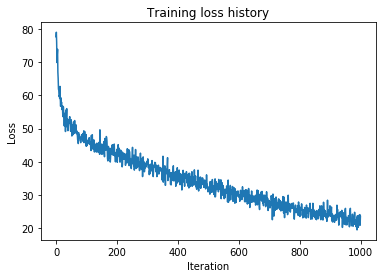

In [22]:
iterations = 10000
batch_size = 50
store_every = 10
train_images = 5000
loss_history = []
small_data = load_coco_data(max_train=train_images)


optimizer = tf.train.GradientDescentOptimizer(5e-3)
captioning_model = CaptioningRNN(data['word_to_idx'], input_dim=data['train_features'].shape[1], hidden_dim=256, wordvec_dim=128)

for epoch in range(iterations):
    minibatch = sample_coco_minibatch(small_data, batch_size=batch_size, split='train')
    captions, features, urls = minibatch
    
    optimizer.minimize(lambda: captioning_model.get_loss(features, captions))
    
    if epoch % store_every == 0:
        cur_loss = captioning_model.get_loss(features, captions)
        loss_history.append(cur_loss)

        
plt.plot(loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

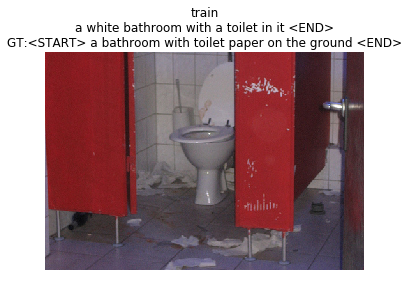

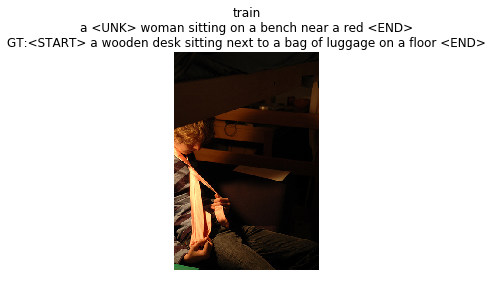

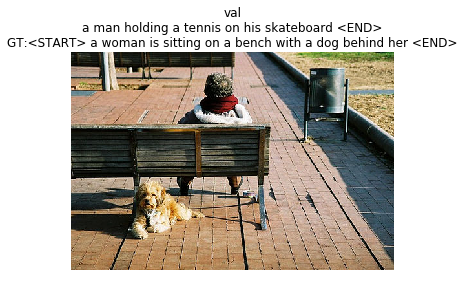

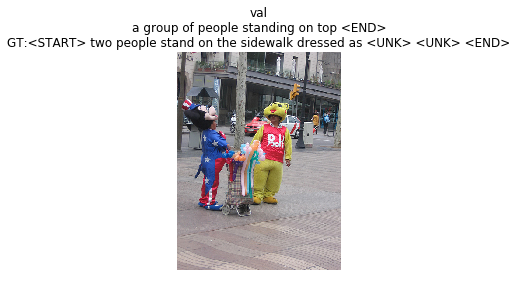

In [23]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = captioning_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('{}\n{}\nGT:{}'.format(split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()